In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression 
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm

warnings.filterwarnings('ignore')
from myworkspaceutils.datasets.micro_rna import MiRNA_GSE120584_Binary

In [2]:
data_dir = f"{Path.cwd().parent}/mirna_data"
mirna = MiRNA_GSE120584_Binary(data_dir)

In [3]:
meta_data_ad, series_mtrx_ad = mirna.load_data(cohort="discovery", label="ad")
meta_data_vad, series_mtrx_vad = mirna.load_data(cohort="discovery", label="vad")
meta_data_dlb, series_mtrx_dlb = mirna.load_data(cohort="discovery", label="dlb")

In [4]:
meta_data_ad.head()

,sample_id,age,sex,apoe4,label
0,GSM3403761,79,0,0,1
1,GSM3403762,77,0,1,1
2,GSM3403763,76,0,0,1
3,GSM3403764,88,0,1,1
4,GSM3403765,74,1,0,1


In [5]:
series_mtrx_ad.shape

(2547, 656)

In [6]:
def calculate_z_values(series_mtrx, meta_data): 
    y = meta_data[['sample_id','label']].set_index('sample_id')
    X_mirna = series_mtrx.set_index("ID_REF").T
    covariates = meta_data[['sample_id','age', 'sex', 'apoe4']]
    
    z_values = {}
    
    for mirna in tqdm(X_mirna.columns):
        X = pd.concat([X_mirna[[mirna]], covariates.set_index('sample_id')], axis=1)  
        model = LogisticRegression(penalty=None, max_iter=1000)
        model.fit(X, y) 

        X_sm = sm.add_constant(X)
        logit_model = sm.Logit(y, X_sm)
        result = logit_model.fit(disp=0)
        
        coef = result.params[1]
        se = result.bse[1]
        z = coef / se
        
        z_values[mirna] = z
    
    return pd.Series(z_values)


# Z-Values

In [7]:
def plot_histogram(z_values, title="'DISCOVERY Cohort: miRNA Association Strength'"):
    plt.figure(figsize=(10, 6))

    # Histogram
    plt.hist(z_values, bins=50, alpha=0.7, edgecolor='black', density=True)

    # thresholds
    thresholds = [2.0, 3.0, 4.0, 4.5, 5.0]
    colors = ['orange', 'yellow', 'green', 'red', 'purple']

    for T, color in zip(thresholds, colors):
        plt.axvline(x=T, color=color, linestyle='--', alpha=0.7, 
                label=f'T={T} ({ (np.abs(z_values) > T).sum()} miRNAs)')
        plt.axvline(x=-T, color=color, linestyle='--', alpha=0.7)

    plt.axvline(x=0, color='black', linewidth=1)
    plt.xlabel('z-value')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend(loc='upper left', fontsize=9)
    plt.show()

In [8]:
def get_z_value_summary(z_values):
    summary_data = []
    for T in [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
        n_above = (z_values > T).sum()
        n_below = (z_values < -T).sum()
        n_total = n_above + n_below
        
        summary_data.append({
            'Threshold (T)': T,
            'Total miRNAs': n_total,
            'Upregulated': n_above,
            'Downregulated': n_below,
            'Percentage': f"{n_total/2547*100:.1f}%"
        })

    # to df
    summary_df = pd.DataFrame(summary_data)
    return summary_df

## AD

In [9]:
z_values_ad = calculate_z_values(series_mtrx_ad, meta_data_ad)

# Check results
print(f"Calculated z-values for {len(z_values_ad)} miRNAs")
print("\nZ-value statistics:")
print(f"Mean: {z_values_ad.mean():.3f}")
print(f"Std: {z_values_ad.std():.3f}")
print(f"Min: {z_values_ad.min():.3f}")
print(f"Max: {z_values_ad.max():.3f}")
print(f"Number with |z| > 2: {(np.abs(z_values_ad) > 2).sum()}")

100%|██████████| 2547/2547 [00:29<00:00, 86.63it/s]

Calculated z-values for 2547 miRNAs

Z-value statistics:
Mean: 0.849
Std: 1.689
Min: -6.272
Max: 6.527
Number with |z| > 2: 694


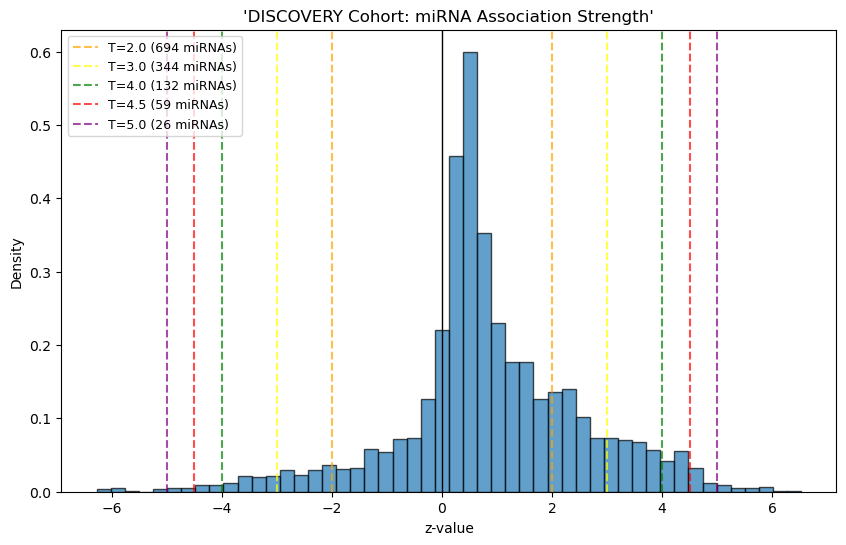

,Threshold (T),Total miRNAs,Upregulated,Downregulated,Percentage
0,2.0,694,544,150,27.2%
1,2.5,486,380,106,19.1%
2,3.0,344,272,72,13.5%
3,3.5,229,183,46,9.0%
4,4.0,132,108,24,5.2%
5,4.5,59,45,14,2.3%
6,5.0,26,18,8,1.0%


In [10]:
plot_histogram(z_values_ad)
  
get_z_value_summary(z_values_ad)

In [12]:
z_values_ad.to_csv(f'{data_dir}/z_values_ad_discovery.csv') 

## VAD

In [13]:
z_values_vad = calculate_z_values(series_mtrx_vad, meta_data_vad)

100%|██████████| 2547/2547 [00:26<00:00, 95.58it/s] 


In [14]:
# results
print(f"Calculated z-values for {len(z_values_vad)} miRNAs")
print("\nZ-value statistics:")
print(f"Mean: {z_values_vad.mean():.3f}")
print(f"Std: {z_values_vad.std():.3f}")
print(f"Min: {z_values_vad.min():.3f}")
print(f"Max: {z_values_vad.max():.3f}")
print(f"Number with |z| > 2: {(np.abs(z_values_vad) > 2).sum()}")

Calculated z-values for 2547 miRNAs

Z-value statistics:
Mean: 1.745
Std: 1.670
Min: -4.648
Max: 5.911
Number with |z| > 2: 1056


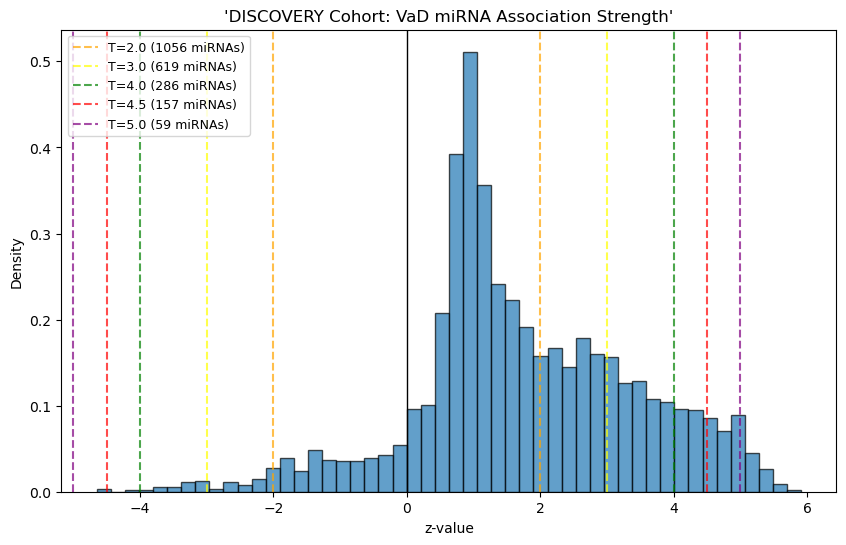

,Threshold (T),Total miRNAs,Upregulated,Downregulated,Percentage
0,2.0,1056,1004,52,41.5%
1,2.5,845,814,31,33.2%
2,3.0,619,598,21,24.3%
3,3.5,428,421,7,16.8%
4,4.0,286,283,3,11.2%
5,4.5,157,156,1,6.2%
6,5.0,59,59,0,2.3%


In [15]:
plot_histogram(z_values_vad, title="'DISCOVERY Cohort: VaD miRNA Association Strength'")
  
get_z_value_summary(z_values_vad)



In [16]:
z_values_dlb = calculate_z_values(series_mtrx_dlb, meta_data_dlb)
print(f"Calculated z-values for {len(z_values_dlb)} miRNAs")
print("\nZ-value statistics:")
print(f"Mean: {z_values_dlb.mean():.3f}")
print(f"Std: {z_values_dlb.std():.3f}")
print(f"Min: {z_values_dlb.min():.3f}")
print(f"Max: {z_values_dlb.max():.3f}")
print(f"Number with |z| > 2: {(np.abs(z_values_dlb) > 2).sum()}")

100%|██████████| 2547/2547 [00:25<00:00, 99.57it/s] 

Calculated z-values for 2547 miRNAs

Z-value statistics:
Mean: 0.716
Std: 1.715
Min: -5.259
Max: 6.102
Number with |z| > 2: 686


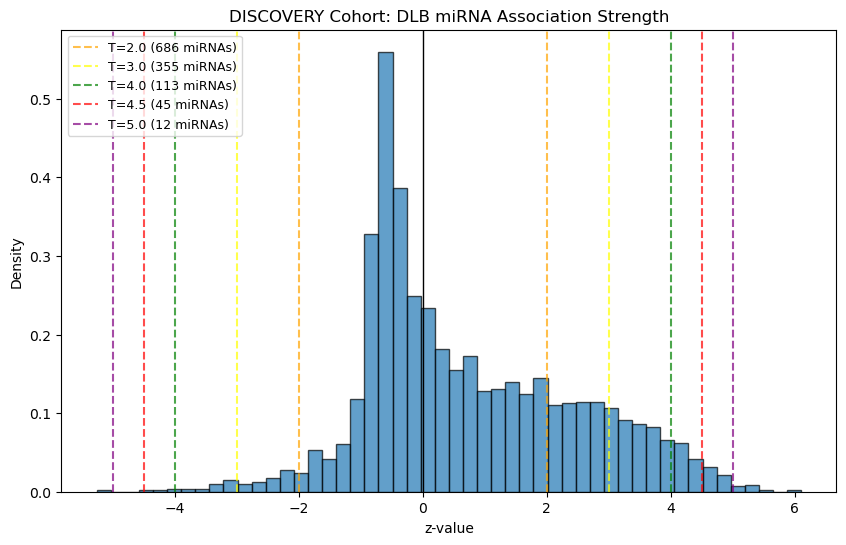

,Threshold (T),Total miRNAs,Upregulated,Downregulated,Percentage
0,2.0,686,618,68,26.9%
1,2.5,510,471,39,20.0%
2,3.0,355,331,24,13.9%
3,3.5,229,221,8,9.0%
4,4.0,113,110,3,4.4%
5,4.5,45,43,2,1.8%
6,5.0,12,11,1,0.5%


In [17]:
plot_histogram(z_values_dlb, title="DISCOVERY Cohort: DLB miRNA Association Strength")
 

get_z_value_summary(z_values_dlb) 